In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, GlobalAveragePooling1D, Embedding, Flatten
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Data pre-processing
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#from scipy import stats
from numpy import savetxt

import seaborn as sns

C:\Users\ali.zaheer\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
C:\Users\ali.zaheer\Miniconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Load data set

In [2]:
imdb_df = pd.read_csv('sentiment labelled sentences/imdb_labelled.txt',delimiter='\t',
                        header=None, 
                        names=['review', 'sentiment'])

### Data Prep, EDA and Data Cleaning

In [3]:
imdb_df.columns.to_list()

['review', 'sentiment']

['review', 'sentiment']

In [4]:
imdb_df.shape

(748, 2)

(748, 2)

In [5]:
imdb_df.describe

<bound method NDFrame.describe of                                                 review  sentiment
0    A very, very, very slow-moving, aimless movie ...          0
1    Not sure who was more lost - the flat characte...          0
2    Attempting artiness with black & white and cle...          0
3         Very little music or anything to speak of.            0
4    The best scene in the movie was when Gerardo i...          1
..                                                 ...        ...
743  I just got bored watching Jessice Lange take h...          0
744  Unfortunately, any virtue in this film's produ...          0
745                   In a word, it is embarrassing.            0
746                               Exceptionally bad!            0
747  All in all its an insult to one's intelligence...          0

[748 rows x 2 columns]>

<bound method NDFrame.describe of                                                 review  sentiment
0    A very, very, very slow-moving, aimless movie ...          0
1    Not sure who was more lost - the flat characte...          0
2    Attempting artiness with black & white and cle...          0
3         Very little music or anything to speak of.            0
4    The best scene in the movie was when Gerardo i...          1
..                                                 ...        ...
743  I just got bored watching Jessice Lange take h...          0
744  Unfortunately, any virtue in this film's produ...          0
745                   In a word, it is embarrassing.            0
746                               Exceptionally bad!            0
747  All in all its an insult to one's intelligence...          0

[748 rows x 2 columns]>

In [6]:
imdb_df.review.head()

0    A very, very, very slow-moving, aimless movie ...
1    Not sure who was more lost - the flat characte...
2    Attempting artiness with black & white and cle...
3         Very little music or anything to speak of.  
4    The best scene in the movie was when Gerardo i...
Name: review, dtype: object

0    A very, very, very slow-moving, aimless movie ...
1    Not sure who was more lost - the flat characte...
2    Attempting artiness with black & white and cle...
3         Very little music or anything to speak of.  
4    The best scene in the movie was when Gerardo i...
Name: review, dtype: object

In [7]:
imdb_df.sentiment.head()

0    0
1    0
2    0
3    0
4    1
Name: sentiment, dtype: int64

0    0
1    0
2    0
3    0
4    1
Name: sentiment, dtype: int64

In [8]:
# Data type in the series
print ('Sentiment Data Type: {}'.format(imdb_df.sentiment.dtypes))
print ('Sentiment Data Type: {}'.format(imdb_df.review.dtype))
#imdb_df.review = imdb_df.review.astype(str)
#print(imdb_df.dropna(inplace=True))

Sentiment Data Type: int64
Sentiment Data Type: object
Sentiment Data Type: int64
Sentiment Data Type: object


In [9]:
# count of zero and positives values
imdb_df.sentiment.value_counts()

1    386
0    362
Name: sentiment, dtype: int64

1    386
0    362
Name: sentiment, dtype: int64

C:\Users\ali.zaheer\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\ali.zaheer\Miniconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


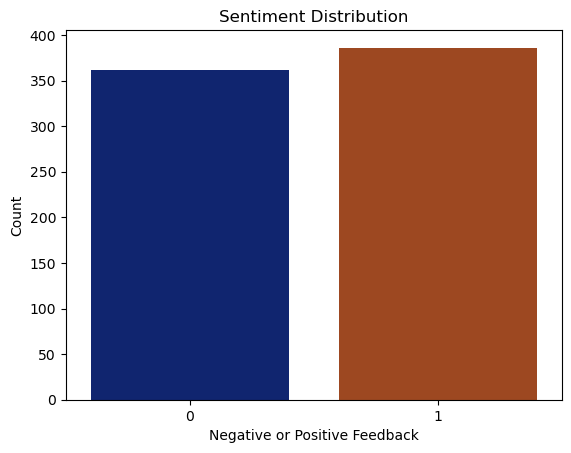

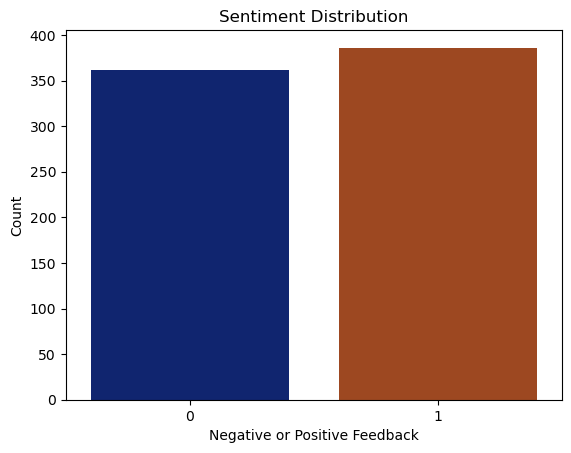

In [10]:
# visualize sentiments
sns.countplot(imdb_df.sentiment, x=imdb_df.sentiment, palette='dark')
plt.title('Sentiment Distribution')
plt.ylabel('Count')
plt.xlabel('Negative or Positive Feedback')
plt.show()

In [11]:
# Check if there are any null values
imdb_df.isna().sum()

review       0
sentiment    0
dtype: int64

review       0
sentiment    0
dtype: int64

# Idenitfy outliers in the review length
imdb_df.review.str.len().plot.box()

### Remove outlier from the dataset

outliers = imdb_df.review.str.len().quantile(0.99)
q_low = imdb_df.review.str.len().quantile(0.01)
q_hi  = imdb_df.review.str.len().quantile(0.99)

imdb_df = imdb_df[(imdb_df.review.str.len() < q_hi) & (imdb_df.review.str.len() > q_low)]

# Idenitfy outliers in the review length
imdb_df.review.str.len().plot.box()

# Investigate distribution of Revenue column using histogram
imdb_df.review.str.len().plot(kind = "hist", title = 'Review length Histogram')

In [12]:
# check for special characters and numbers from the reviews
imdb_df['anySpecialChar'] = imdb_df.review.str.isalpha()
imdb_df[imdb_df['anySpecialChar'] == 'True']

,review,sentiment,anySpecialChar


,review,sentiment,anySpecialChar


In [13]:
#drop the anySpecialChar
imdb_df = imdb_df.drop(columns='anySpecialChar')

# remove special characters and numbers from the reviews
import re
def remove_special_char(data):
    pat = r'[^a-zA-z.,!?/:;\"\'\s]' # regex to identify special characters
    return (re.sub(pat, '', data))
#remove_special_characters('“007 Not sure@% #fun! 558923 do# ** of it.? $500USD!”')

# Remove Special characters
imdb_df['review'] = imdb_df.review.apply(remove_special_char)

In [14]:
# Convert data to lowercase
imdb_df['review'] = imdb_df.review.apply(lambda x: " ".join(x.lower() for x in x.split()))

In [15]:
print('Min lenght of review: ',imdb_df.review.str.len().min())
print('Median lenght of review: ',imdb_df.review.str.len().median())
print('Max lenght of review: ',imdb_df.review.str.len().max())

Min lenght of review:  5
Median lenght of review:  70.0
Max lenght of review:  7747
Min lenght of review:  5
Median lenght of review:  70.0
Max lenght of review:  7747


In [16]:
# Extract sentence and labels
sentence = np.array(imdb_df['review'])
rating = np.array(imdb_df['sentiment'])

In [17]:
type(rating)

numpy.ndarray

numpy.ndarray

In [18]:
# find max lenght of the list in the encoded_docs
def FindMaxLength(lst):
    maxList = max((x) for x in lst)
    maxLength = max(len(x) for x in lst )
    minLength = min(len(x) for x in lst )
    #return maxList, maxLength
    return maxLength, minLength
     
# Driver Code
#print('Max lenght: {}, Min length: {}'.format(FindMaxLength(X_train)[0],FindMaxLength(X_train)[1]))

In [19]:
# visualize accuracy and loss of the first model
def plot_learningCurve(history, epochs):
    epoch_range = range(1, epochs+1)
    plt.plot(epoch_range, history.history['accuracy'])
    plt.plot(epoch_range, history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()
    plt.plot(epoch_range, history.history['loss'])
    plt.plot(epoch_range, history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='upper left')
    plt.show()

In [20]:
# Identify stopwords
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ali.zaheer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ali.zaheer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
stopwords = set(stopwords.words('english'))

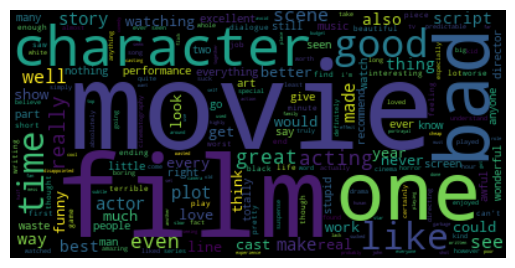

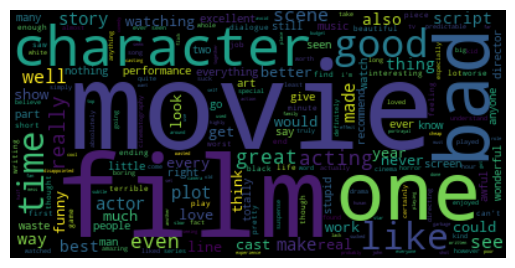

In [22]:
stopwords.update(["br", "href"])

textt = " ".join(review for review in sentence)

wordcloud = WordCloud(stopwords=stopwords).generate(textt)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig('wordcloud11.png')
plt.show()

### Split into training and testing sets.

In [23]:
# split the data 80/20
X_train, X_test, Y_train, Y_test = train_test_split(sentence, rating, test_size=0.2, random_state = 1000, stratify=rating)

In [24]:
# train and test dataset
print('Train dataset: ', X_train.shape)
print('test dataset: ', X_test.shape)
print('Train dataset: ', Y_train.shape)
print('test dataset: ', Y_test.shape)

Train dataset:  (598,)
test dataset:  (150,)
Train dataset:  (598,)
test dataset:  (150,)
Train dataset:  (598,)
test dataset:  (150,)
Train dataset:  (598,)
test dataset:  (150,)


In [25]:
#Apply the tokenizer and pad to a max length
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_s = tokenizer.texts_to_sequences(X_train)
X_test_s = tokenizer.texts_to_sequences(X_test)

In [26]:
# Max sequence length
print('Max lenght: {}, Min length: {}'.format(FindMaxLength(X_train_s)[0],FindMaxLength(X_train_s)[1]))

Max lenght: 1400, Min length: 1
Max lenght: 1400, Min length: 1


In [27]:
print('Max lenght: {}'.format(FindMaxLength(X_train)[0]))

Max lenght: 7747
Max lenght: 7747


In [28]:
#Idenitfy vocabolary
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: ', len(tokenizer.word_index)+1)

Vocabulary Size:  2792
Vocabulary Size:  2792


In [29]:
#Sample of the Vocabulary data
list(tokenizer.word_index.items())[50:60]

[('even', 51),
 ('his', 52),
 ('out', 53),
 ('who', 54),
 ('great', 55),
 ('characters', 56),
 ('my', 57),
 ('see', 58),
 ('no', 59),
 ('story', 60)]

[('even', 51),
 ('his', 52),
 ('out', 53),
 ('who', 54),
 ('great', 55),
 ('characters', 56),
 ('my', 57),
 ('see', 58),
 ('no', 59),
 ('story', 60)]

### Padding the sentence

In [30]:
X_train = pad_sequences(X_train_s, maxlen=FindMaxLength(X_train_s)[0])
X_test = pad_sequences(X_test_s, maxlen=FindMaxLength(X_test_s)[0])

In [31]:
### Save the training and test data

savetxt('padded_X_train.csv', X_train)
savetxt('padded_X_test.csv', X_test)
savetxt('rating_Y_train.csv', Y_train)
savetxt('rating_Y_test.csv', Y_test)

In [32]:
# find out max embedding
max_embd = int(round(np.sqrt(vocab_size),0))
print(max_embd)

53
53


### Sentiments, padded and encoded

In [33]:
from keras.backend import clear_session
clear_session()

# early stopping monitor
esm = EarlyStopping(patience=2)

model = Sequential() 
model.add(Embedding(vocab_size, output_dim=max_embd, input_length=FindMaxLength(X_train_s)[0]) )
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid')) 
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])  
print(model.summary()) 

Model: "sequential"
_________________________________________________________________
Model: "sequential"
 Layer (type)                Output Shape              Param #   
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1400, 53)          147976    
                                                                 
 lstm (LSTM)                 (None, 50)                20800     
                                                                 
 embedding (Embedding)       (None, 1400, 53)          147976    
                                                                 
 lstm (LSTM)                 (None, 50)                20800     
 dropout (Dropout)           (None, 50)                0         
                                                                 
                                                                 
 dropout (Dropout)           (None, 

In [34]:
# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [35]:
history = model.fit(X_train, Y_train,
                    validation_split=0.2,
                    epochs=10,
                    callbacks=esm,
                    batch_size=32) # slicing the data into "batches" of size batch_size, 
                                   # and repeatedly iterating over the entire dataset for a given number of epochs

Epoch 1/10
Epoch 1/10
15/15 [==============================] - 35s 2s/step - loss: 0.6937 - accuracy: 0.4874 - val_loss: 0.6908 - val_accuracy: 0.6417
Epoch 2/10
Epoch 2/10
 5/15 [=========>....................] - ETA: 20s - loss: 0.6896 - accuracy: 0.6000


KeyboardInterrupt


KeyboardInterrupt



In [ ]:
#train_loss, train_accuracy = model.evaluate(X_train, Y_train, verbose=False)
#print("Training Accuracy: {:.4f} Testing Loss {:.4f}".format(train_accuracy,train_loss))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f} Testing Loss {:.4f}".format(accuracy,loss))

In [ ]:
plot_learningCurve(history,len(history.epoch))

In [ ]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=FindMaxLength(X_train_s)[0])
    prediction = int(model.predict(tw).round().item())
    print("Predicted label: ", prediction)

imdb_df

### Test the model by adding sentances

In [ ]:
test_sentence2 = "Initially the local sites in the film, which was filmed here in Buffalo, intrigued me"
predict_sentiment(test_sentence2)

In [ ]:
test_sentence2 = "I am not going to watch this movie again"
predict_sentiment(test_sentence2)

### Saving the model

In [ ]:
model.save('D213Task2.keras')